# RNN for Text Classification

### Imports and Constants

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
%matplotlib inline

import os, glob, re

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sn

import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SimpleRNN, GRU, Dropout, Bidirectional, BatchNormalization, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

from nltk import word_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
isOnColab = True

if isOnColab == True:
  DIR_PREFIX = './drive/My Drive/NLP/'
else:
  DIR_PREFIX = '../'

DATASET_DIR = DIR_PREFIX + 'dataset/'
MODEL_SAVE_DIR = DIR_PREFIX + 'models/'

TRAIN_FILE = DATASET_DIR + 'train.csv'
VAL_FILE = DATASET_DIR + 'val.csv'
TEST_FILE = DATASET_DIR + 'test.csv'

MAX_SENTENCE_LENGTH = 100
EMBEDDING_DIM = 100

### Load Dataset

In [0]:
def load_dataset(file_name):
  dF = pd.read_csv(file_name, delimiter=',')
  return (dF['Text'], dF['Label'])

In [5]:
raw_train_X, raw_train_Y = load_dataset(TRAIN_FILE)
raw_val_X, raw_val_Y     = load_dataset(VAL_FILE)
raw_test_X, raw_test_Y   = load_dataset(TEST_FILE)

print('train_X: {0}\ttrain_Y: {1}'.format(len(raw_train_X), len(raw_train_Y)))
print('val_X: {0}\tval_Y: {1}'.format(len(raw_val_X), len(raw_val_Y)))
print('test_X: {0}\ttest_Y: {1}'.format(len(raw_test_X), len(raw_test_Y)))

train_X: 38084	train_Y: 38084
val_X: 6721	val_Y: 6721
test_X: 11202	test_Y: 11202


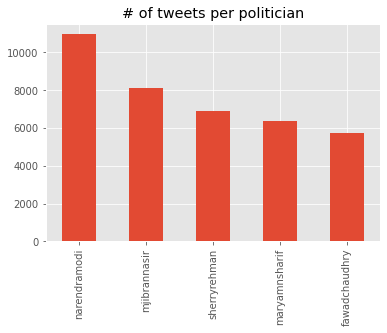

In [6]:
plot = raw_train_Y.value_counts().sort_values(ascending=False).plot(kind='bar', y='# of tweets', title='# of tweets per politician') 

### Preprocess Data

In [0]:
def preprocessing(data):
    processed = []
    for each in data:
        target = each

        # tokenize words
        target = word_tokenize(target)

        # truncate sentence for MAX_SENTENCE_LENGTH
        target = target[:MAX_SENTENCE_LENGTH]

        # finally append to processed
        processed.append(target)

    return processed

In [0]:
processed_train_X = preprocessing(raw_train_X)
processed_val_X = preprocessing(raw_val_X)
processed_test_X = preprocessing(raw_test_X)

In [9]:
# create one-hot labels
labels_dict = {}

for index, x in enumerate(list(raw_train_Y.unique())):
  labels_dict[x] = index

# replace string labels with corresponding numeric value from labels_dict
train_Y = raw_train_Y.apply(lambda x: labels_dict[x])
val_Y = raw_val_Y.apply(lambda x: labels_dict[x])
test_Y = raw_test_Y.apply(lambda x: labels_dict[x])

# convert to one-hot encoding
train_Y = to_categorical(train_Y)
val_Y = to_categorical(val_Y)
test_Y = to_categorical(test_Y)

# print
train_Y, val_Y, test_Y

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]], dtype=float32), array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32))

In [10]:
# Tokenize texts
tokenizer = Tokenizer(oov_token='[UNK]')
tokenizer.fit_on_texts(processed_train_X)

print('word counts:', tokenizer.word_counts)
print('document_count:', tokenizer.document_count)
print('vocab_size:', len(tokenizer.word_index))

word counts: OrderedDict([('ppp', 700), ('is', 12575), ('only', 1454), ('option', 46), ('for', 11300), ('modern', 73), ('pak', 1205), ('we', 5042), ('need', 1043), ('to', 25509), ('rebuild', 6), ('team', 598), ('govern', 7), ('though', 99), ('nt', 967), ('happy', 566), ('with', 6129), ('even', 880), ('present', 143), ('sindh', 551), ('govt', 1721), ('all', 3754), ('the', 30737), ('indian', 738), ('journalists', 77), ('and', 12922), ('politician', 74), ('whove', 11), ('set', 236), ('bar', 87), ('humanity', 80), ('so', 1762), ('low', 80), ('that', 4142), ('they', 1936), ('rejoice', 5), ('in', 16883), ('fact', 164), ('ongoing', 25), ('curfew', 18), ('#', 10882), ('kashmir', 359), ('now', 1184), ('its', 2397), ('31st', 15), ('day', 1219), ('didnt', 330), ('result', 79), ('any', 942), ('loss', 179), ('of', 22873), ('life', 917), ('forgetting', 12), ('living', 132), ('more', 1503), ('than', 657), ('just', 1107), ('breathing', 8), ('budget', 152), ('2015', 55), ('has', 3405), ('a', 13873), ('

In [11]:
train_X = tokenizer.texts_to_sequences(processed_train_X)
val_X = tokenizer.texts_to_sequences(processed_val_X)
test_X = tokenizer.texts_to_sequences(processed_test_X)

print(train_X[:3])

[[139, 8, 63, 2263, 9, 1523, 77, 14, 95, 3, 9121, 164, 3, 8377, 1139, 103, 180, 13, 112, 775, 185, 53], [3, 27, 2, 129, 1448, 7, 1505, 6373, 448, 2, 1296, 9, 1397, 51, 1398, 21, 48, 10063, 5, 2, 683, 21, 2, 3595, 4565, 5, 10, 291, 79, 5, 43, 5176, 76, 320, 1411, 5, 104, 609, 4, 109, 6011, 21, 842, 8, 59, 148, 88, 7724], [727, 1963, 30, 6, 7725, 497, 11, 391, 186, 232, 7726, 824, 2, 6012, 21781, 17, 7228, 11, 464, 8378, 482, 2350]]


In [12]:
# pad sequences

train_X = pad_sequences(train_X,  maxlen=MAX_SENTENCE_LENGTH, padding='post')
val_X = pad_sequences(val_X,      maxlen=MAX_SENTENCE_LENGTH, padding='post')
test_X = pad_sequences(test_X,    maxlen=MAX_SENTENCE_LENGTH, padding='post')

print(train_X[:3])

[[  139     8    63  2263     9  1523    77    14    95     3  9121   164
      3  8377  1139   103   180    13   112   775   185    53     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    3    27     2   129  1448     7  1505  6373   448     2  1296     9
   1397    51  1398    21    48 10063     5     2   683    21     2  3595
   4565     5    10   291    79     5    43  5176    76   320  1411     5
    104   609     4   109  6011    21   842     8    59   148    88  7724
      0     0     0     0     0     0     0     0     0     0     0     0
      0    

### Prepare Embeddings

In [0]:
# !curl http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip -o glove.6B.zip
# !curl http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip -o glove.twitter.27B.zip
# !unzip glove.6B.zip
# !unzip glove.twitter.27B.zip
# !mv glove.6B.100d.txt drive/My\ Drive/NLP/dataset/
# !mv glove.twitter.27B.100d.txt drive/My\ Drive/NLP/dataset/

In [0]:
# GLOVE_DIR = DATASET_DIR + 'glove.twitter.27B.100d.txt'
GLOVE_DIR = DATASET_DIR + 'glove.6B.100d.txt'

In [15]:
# load embeddings of GLoVE
embeddings_dict = {}

with open(GLOVE_DIR, 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector

print('embeddings_dict:', len(embeddings_dict))

embeddings_dict: 400000


In [16]:
# padding
embeddings_dict['[UNK]'] = np.zeros((EMBEDDING_DIM,), dtype='float32')

# load embeddings for train dataset
for X in processed_train_X:
  for sentence in X:
    words = sentence.split(' ')
    for word in words:
      try:
        embdng = embeddings_dict[word]
      except KeyError:
        embdng = np.zeros((EMBEDDING_DIM,), dtype='float32')
    
      # add embedding to DICT
      embeddings_dict[word] = embdng

print('embeddings_dict:', len(embeddings_dict))

# load embeddings for validation dataset
for X in processed_val_X:
  for sentence in X:
    words = sentence.split(' ')
    for word in words:
      try:
        embdng = embeddings_dict[word]
      except KeyError:
        embdng = np.zeros((EMBEDDING_DIM,), dtype='float32')
    
      # add embedding to DICT
      embeddings_dict[word] = embdng

print('embeddings_dict:', len(embeddings_dict))

# load embeddings for test dataset
for X in processed_test_X:
  for sentence in X:
    words = sentence.split(' ')
    for word in words:
      try:
        embdng = embeddings_dict[word]
      except KeyError:
        embdng = np.zeros((EMBEDDING_DIM,), dtype='float32')
    
      # add embedding to DICT
      embeddings_dict[word] = embdng

print('embeddings_dict:', len(embeddings_dict))

embeddings_dict: 419193
embeddings_dict: 421964
embeddings_dict: 426476


In [17]:
# create matrix of embeddings
EMBEDDING_MATRIX = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
  try:
    vector = embeddings_dict[word]
  except KeyError:
    vector = np.zeros((EMBEDDING_DIM,), dtype='float32')
  # append vector
  EMBEDDING_MATRIX[i] = vector 

print('EMBEDDING_MATRIX', EMBEDDING_MATRIX.shape, EMBEDDING_MATRIX)

EMBEDDING_MATRIX (48048, 100) [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### RNN Model

In [0]:
# setup callbacks

MODEL_SAVE_AT = MODEL_SAVE_DIR + 'rnn_plain/'
if not os.path.exists(MODEL_SAVE_AT):
  os.makedirs(MODEL_SAVE_AT)


filepath = MODEL_SAVE_AT + 'model' + '.hdf5'
logfilepath = MODEL_SAVE_AT + 'logs_' + 'model' + '.csv'

reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=3,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]

In [37]:
# Model Code
model = None 
inp_layer = Input(shape=(MAX_SENTENCE_LENGTH,))

layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM, 
                  input_length=MAX_SENTENCE_LENGTH, weights=[EMBEDDING_MATRIX], trainable=True)(inp_layer)

layer = SpatialDropout1D(0.3)(layer)
layer = SimpleRNN(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True, activation='tanh')(layer)
layer = BatchNormalization()(layer)

layer = SpatialDropout1D(0.3)(layer)
layer = SimpleRNN(128, dropout=0.6, recurrent_dropout=0.6, activation='tanh')(layer)
layer = BatchNormalization()(layer)

layer = Dropout(0.4)(layer)
layer = Dense(len(labels_dict), activation='sigmoid')(layer)

output_layer = layer
model = Model(inputs=inp_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          4804800   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 100, 100)          0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 100, 300)          120300    
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 300)          1200      
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 100, 300)          0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 128)               5491

#### Training

In [0]:
EPOCHS = 50
BATCH_SIZE = 32

In [39]:
hist = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=EPOCHS, batch_size=BATCH_SIZE,
               verbose=1, callbacks=callbacks_list)

Epoch 1/50
1191/1191 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.2433
Epoch 00001: val_accuracy improved from -inf to 0.28240, saving model to ./drive/My Drive/NLP/models/rnn_plain/model.hdf5
1191/1191 [==============================] - 284s 239ms/step - loss: 0.5663 - accuracy: 0.2433 - val_loss: 0.4946 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 2/50
1191/1191 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.2787
Epoch 00002: val_accuracy did not improve from 0.28240
1191/1191 [==============================] - 282s 237ms/step - loss: 0.5008 - accuracy: 0.2787 - val_loss: 0.4957 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 3/50
1191/1191 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.2827
Epoch 00003: val_accuracy did not improve from 0.28240
1191/1191 [==============================] - 284s 238ms/step - loss: 0.4979 - accuracy: 0.2827 - val_loss: 0.4948 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 4/50
1191/1191 [==

#### Inference

In [40]:
predictions = model.predict(test_X, batch_size=BATCH_SIZE, verbose=1)

351/351 [==============================] - 5s 14ms/step


Confusion Matrix:
 [[   0    0 1636    0    0]
 [   0    0 2383    0    0]
 [   0    0 3267    0    0]
 [   0    0 2016    0    0]
 [   0    0 1900    0    0]]


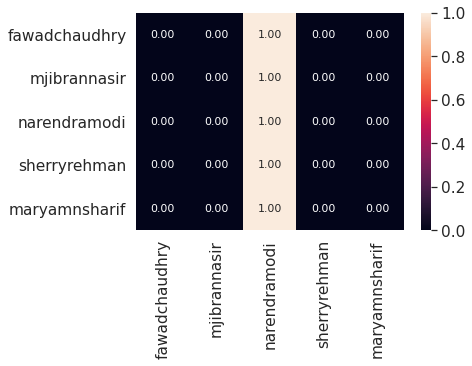

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1636
           1       0.00      0.00      0.00      2383
           2       0.29      1.00      0.45      3267
           3       0.00      0.00      0.00      2016
           4       0.00      0.00      0.00      1900

    accuracy                           0.29     11202
   macro avg       0.06      0.20      0.09     11202
weighted avg       0.09      0.29      0.13     11202



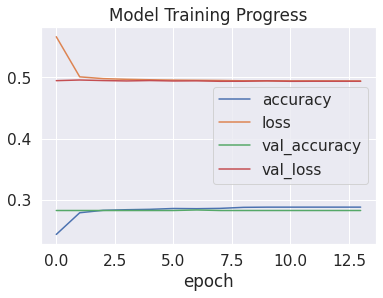

In [41]:
labels_list = labels_dict.keys()

test_Y_max = np.argmax(test_Y, axis=-1)
predictions_max = np.argmax(predictions, axis=-1)

####################################### CONFUSION MATRIX

cm = confusion_matrix(test_Y_max, predictions_max)
print('Confusion Matrix:\n', cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labels_list, labels_list)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

report_labels = [str(x) for x in labels_dict.values()]
#########################################################

################################### CLASSIFICATION REPORT
print("\n\nClassification Report\n", classification_report(test_Y_max, predictions_max, 
                                                       labels=list(labels_dict.values()), target_names=report_labels))
#########################################################


################################# MODEL TRAINING PROGRESS
logsdF = pd.read_csv(logfilepath, delimiter=',')
ax = plt.gca()

logsdF.plot(kind='line', x='epoch', y='accuracy', ax=ax)
logsdF.plot(kind='line', x='epoch', y='loss', ax=ax)
logsdF.plot(kind='line', x='epoch', y='val_accuracy', ax=ax)
logsdF.plot(kind='line', x='epoch', y='val_loss', ax=ax)
plt.legend()
plt.title('Model Training Progress')
plt.show()
#########################################################

### GRU Model

In [0]:
# setup callbacks

MODEL_SAVE_AT = MODEL_SAVE_DIR + 'gru/'
if not os.path.exists(MODEL_SAVE_AT):
  os.makedirs(MODEL_SAVE_AT)


filepath = MODEL_SAVE_AT + 'model' + '.hdf5'
logfilepath = MODEL_SAVE_AT + 'logs_' + 'model' + '.csv'

reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=3,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]

In [45]:
# Model Code

inp_layer = Input(shape=(MAX_SENTENCE_LENGTH,))

layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM, 
                  input_length=MAX_SENTENCE_LENGTH, weights=[EMBEDDING_MATRIX], trainable=True)(inp_layer)

layer = SpatialDropout1D(0.3)(layer)
layer = Bidirectional( GRU(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True) )(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Bidirectional( GRU(128, dropout=0.4, recurrent_dropout=0.4) )(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(len(labels_dict), activation='sigmoid')(layer)

output_layer = layer

model = Model(inputs=inp_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 100)          4804800   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          549888    
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 512)          2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               4930

#### Training

In [0]:
EPOCHS = 50
BATCH_SIZE = 64

In [47]:
hist = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=EPOCHS, batch_size=BATCH_SIZE,
               verbose=1, shuffle=True, callbacks=callbacks_list)

 14/596 [..............................] - ETA: 10:43 - loss: 0.0465 - accuracy: 0.9565

KeyboardInterrupt: ignored

#### Inference

In [48]:
predictions = model.predict(test_X, batch_size=BATCH_SIZE, verbose=1)

176/176 [==============================] - 15s 83ms/step


Confusion Matrix:
 [[1429   81   14   54   58]
 [  56 2027   34  143  123]
 [   9   33 3158   22   45]
 [  68  189   46 1590  123]
 [  51   64   51   76 1658]]


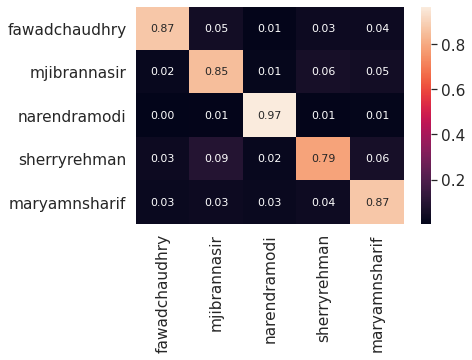



Classification Report
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1636
           1       0.85      0.85      0.85      2383
           2       0.96      0.97      0.96      3267
           3       0.84      0.79      0.82      2016
           4       0.83      0.87      0.85      1900

    accuracy                           0.88     11202
   macro avg       0.87      0.87      0.87     11202
weighted avg       0.88      0.88      0.88     11202



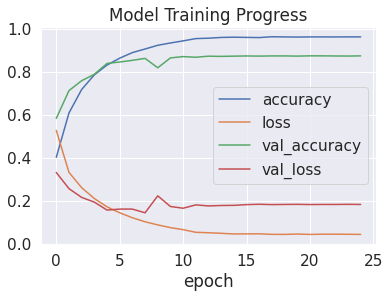

In [49]:
labels_list = labels_dict.keys()

test_Y_max = np.argmax(test_Y, axis=-1)
predictions_max = np.argmax(predictions, axis=-1)

####################################### CONFUSION MATRIX

cm = confusion_matrix(test_Y_max, predictions_max)
print('Confusion Matrix:\n', cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labels_list, labels_list)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

report_labels = [str(x) for x in labels_dict.values()]
#########################################################

################################### CLASSIFICATION REPORT
print("\n\nClassification Report\n", classification_report(test_Y_max, predictions_max, 
                                                       labels=list(labels_dict.values()), target_names=report_labels))
#########################################################


################################# MODEL TRAINING PROGRESS
logsdF = pd.read_csv(logfilepath, delimiter=',')
ax = plt.gca()

logsdF.plot(kind='line', x='epoch', y='accuracy', ax=ax)
logsdF.plot(kind='line', x='epoch', y='loss', ax=ax)
logsdF.plot(kind='line', x='epoch', y='val_accuracy', ax=ax)
logsdF.plot(kind='line', x='epoch', y='val_loss', ax=ax)
plt.legend()
plt.title('Model Training Progress')
plt.show()
#########################################################